<a href="https://colab.research.google.com/github/elyasbny/Optimal-Liquidation-Strategies/blob/main/NN%20with%20randomness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import Module

# Analytical solution
Work of S. Jaimungal https://gist.github.com/sebjai/f87146f994cd5a115b123613ac5bece8#file-liquidation_permanent_price_impact_helper-ipynb which computes the optimal solution for the liquidation problem described in the book Algorithmic and High Frequency Tradin

In [105]:
def inter_extrapolation(x, y, e):
    """ Extrapolation and interpolation.
    
    :param x: a numpy array
    :param y: a numpy array
    :param e: a numpy array, equivalent of x
    :return: a numpy array
    """
    new_x = np.sort(x)
    new_y = y[np.argsort(x)]

    def point_wise(ep):
        if ep < new_x[0]:
            return new_y[0] + (ep - new_x[0]) * (new_y[1] - new_y[0]) / (new_x[1] - new_x[0])
        elif ep > new_x[-1]:
            return new_y[-1] + (ep - new_x[-1]) * (new_y[-1] - new_y[-2]) / (new_x[-1] - new_x[-2])
        else:
            return np.interp([ep], x, y)[0]
    return np.array([point_wise(i) for i in e])


def calculate_inventory_trading_speed(alpha, phi, t, tt, T, b, k):
    """ For given points t, this function solve for the optimal speed of trading as nu, and investor's inventory along the
        optimal path as Q. 
        This function also returns optimal speed of trading as nut, and investor's inventory along the optimal path Qt as a
        function of time, tt, which is a vector of "infinitely" small time interval.
    """
    tau = T - t
    zeta = ((alpha - 0.5 * b) + np.sqrt(k * phi)) / ((alpha - 0.5 * b) - np.sqrt(k * phi))
    gamma = np.sqrt(phi / k)
    chi = np.sqrt(k * phi) * np.divide(1 + zeta * np.exp(2 * gamma * tau), 1 - zeta * np.exp(2 * gamma * tau))
    Q = np.divide(zeta * np.exp(gamma * tau) - np.exp(-gamma * tau), zeta * np.exp(gamma * T) - np.exp(-gamma * T))
    nu = np.multiply(-chi, Q) / k
    Qt = inter_extrapolation(t, Q, tt)
    nut = inter_extrapolation(t, nu, tt)
    return Q, nu, Qt, nut

def slider_plot_inventory_trading_speed(phi, symb, t, tt, T, b, k, labels):
    """ This function returns a dynamic version of above plot with penalty term alpha controlled by a dynamic slider.
        For demonstration purposes, only alpha = 0.01, and alpha = 100 (as an approximation of positive infinity) are plotted.
        To use this function, call this function on the main file using same argument as above function, but remove 'alpha0' 
        parameter since you do not need to specify alpha here. Then, mannually recompile Liquidation_Permanent_Price_Impact file
        to use the slider.
    """
    def update(alpha):
        fig, (ax_inv, ax_trad) = plt.subplots(ncols=2)
        color_idx = np.linspace(0, 1, phi.shape[0])
        for i, line in zip(color_idx, range(0, phi.shape[0])):
            inv_line, trad_line, inv_dot, trad_dot = calculate_inventory_trading_speed(alpha, phi[line], t, tt, T, b, k)
            plt1, = ax_inv.plot(tt, inv_dot, color=plt.cm.rainbow(i), label=labels[line], marker=symb[line], linestyle='None')
            plt2, = ax_trad.plot(tt, trad_dot, color=plt.cm.rainbow(i), label=labels[line], marker=symb[line], linestyle='None')
            plt3, = ax_inv.plot(t, inv_line, linestyle='-', color=plt.cm.rainbow(i))
            plt4, = ax_trad.plot(t, trad_line, linestyle='-', color=plt.cm.rainbow(i))
        ax_inv.legend()
        ax_inv.set_xlabel(r"Time", fontsize=18)
        ax_inv.set_ylabel(r"Inventory", fontsize=18)
        ax_trad.legend()
        ax_trad.set_xlabel(r"Time", fontsize=18)
        ax_trad.set_ylabel(r"Trading Speed", fontsize=18)
        ax_trad.yaxis.set_label_coords(-0.1,0.5)
        plt.suptitle(r"\alpha = " + str(alpha), fontsize=20)
        fig.canvas.draw()
    return interactive(update, {'manual': False}, alpha=widgets.FloatSlider(min=0.01, max=100, step=0.01, value=alpha0))

def solve_pde(T, dt, qmax, dq, k, a, b, alpha, phi, Ndt, Ndq):
    """ This function solves for optimal trading speed in feed back form as nus, and inventory of optimal path as Qs.
    They are used to be presented as a function of time, t.
    """
    t = np.arange(0, T+dt, dt)
    q = np.arange(0, qmax+dq, dq)

    myleg = []

    nus = np.full((Ndt+1, a.shape[0]), np.NaN)
    Qs = np.full((Ndt+1, a.shape[0]), np.NaN)
    Qs[0,:] = qmax

    for i in range(0, a.shape[0], 1):
        xi = (a[i] * k) / ((1 + a[i]) * k) ** (1 + 1/a[i])

        g = np.full((Ndq+1, Ndt+1), np.NaN)
        nu = np.full((Ndq+1, Ndt+1), np.NaN)
        
        g[:, g.shape[1]-1] = -(alpha ** a[i]) / k ** (a[i] - 1) * np.power(q, 1 + a[i]) + 0.5 * b * np.power(q, 2)

        for j in range(Ndt-1, -1, -1):

            # Explicit Scheme
            dqg = (g[1:g.shape[0], j+1] - g[0:(g.shape[0]-1), j+1]) / dq
            g[1:g.shape[0], j] = g[1:g.shape[0], j+1] + dt * (-phi * np.power(q[1:q.shape[0]], 2) + xi * (np.power(-dqg, 1 + 1 / a[i])))
            g[0, j] = 0

            dqg = (g[1:g.shape[0], j] - g[0:(g.shape[0]-1), j]) / dq
            nu[1:nu.shape[0], j] = np.power(-dqg / ((1 + a[i]) * k), 1 / a[i])
            nu[0, j] = 0

            # Implicit-explicit scheme
            g[:, j] = np.real(g[:, j])
            nu[:, j] = np.real(nu[:, j])

        for j in range(0, Ndt, 1):
            nus[j, i] = inter_extrapolation(q, nu[:, j], [Qs[j, i]])
            Qs[j+1, i] = Qs[j, i] - nus[j, i] * dt

        myleg.append("$a=" + str(a[i]) + "$")
    return nus, Qs, myleg, t, q

def plot_multiple(x, y, xlab=None, ylab=None, main=None, labels=None):
    """ This is a plotting function intended to plot multiple Ys for a single x.
    """
    color_idx = np.linspace(0, 1, y.shape[0])
    for i, line in zip(color_idx, range(0, y.shape[0])):
        if labels is not None:
            plt.plot(x, y[line, :], color=plt.cm.rainbow(i), label=labels[line], linestyle='-')
        else:
            plt.plot(x, y[line, :], color=plt.cm.rainbow(i), linestyle='-')
    if xlab is not None:
        plt.xlabel(xlab, fontsize=18)
    if ylab is not None:
        plt.ylabel(ylab, fontsize=18)
    if main is not None:
        plt.title(main, fontsize=12)
    if labels is not None:
        plt.legend()
    plt.show()

# Neural network

In [143]:
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, 1)
 

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [162]:
 def neural_network(I,T,n,price,b,k,alpha,phi):   
    dt=T/n
    model=MLP(2)
    sigma=0.1
    steps=300
    lot_size=1
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    speed_list=[]
    #optimizer = optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
    for i in range(steps):
        optimizer.zero_grad()
        values=torch.cat([torch.ones([lot_size,1,1])*I,torch.ones([lot_size,1,1])*price,torch.zeros([lot_size,1,1]),torch.zeros([lot_size,1,1])],1)
        #values=torch.tensor([[I],[price],[0],[0]])
        values=values.float()
        #inventory_list=[I]
        #speed_list=[]
        
        for i_time in range(n):
            for lot_number in range(lot_size):
              #actions_to_sell = model(torch.cat([values[lot_number,0,-1].reshape(1),torch.ones(1)*number]))
              actions_to_sell = model(torch.cat([values[lot_number,0,-1].reshape(1),torch.ones(1)*i_time/T]))
              #speed_list.append(actions_to_sell.detach().numpy()[0])
              x1=values[lot_number,0,-1]-actions_to_sell*dt
              x2=values[lot_number,1,-1]-b*actions_to_sell*dt+sigma*np.random.normal(0, T/n, 1)[0]
              x3=values[lot_number,1,-1]-k*actions_to_sell
              x4=values[lot_number,3,-1]+x3*actions_to_sell*dt -phi*values[lot_number,0,-1]**2*dt
              x1=x1.resize(1,1,1)
              x2=x2.resize(1,1,1)
              x3=x3.resize(1,1,1)
              x4=x4.resize(1,1,1)
              if lot_number==0:
                valuesnew=torch.cat([x1,x2,x3,x4],1)
              else:
                valuesnew=torch.cat([valuesnew,torch.cat([x1,x2,x3,x4],1)],0)
            values=torch.cat([values,valuesnew],2)
            if i==steps-1 and lot_number==lot_size-1:
              speed_list.append(actions_to_sell.detach().numpy()[0])      
        loss = torch.sum( - values[:,3,n] - values[:,0,n]*(values[:,1,n]-alpha*values[:,0,n]) + phi*values[:,0,-1]**2*T/n )
        #if i%100==0:
        #  print(inventory_list)
        #  print(values)
        #  print(loss)
        loss.backward()
        optimizer.step()
        #print(values)
    inventory_list=values[lot_size-1,0,:].detach().numpy()
    speed_list.append(inventory_list[-1]/dt)
    return inventory_list,speed_list,values   
    

In [146]:
#State with action price (not functional yet) 
 def neural_network2(I,T,n,price,b,k,alpha,phi):   
    dt=T/n
    model=MLP(2)
    model2=MLP(3)
    sigma=0.1
    steps=5000
    lot_size=1
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    speed_list=[]
    #optimizer = optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
    for i in range(steps):
        optimizer.zero_grad()
        values=torch.cat([torch.ones([lot_size,1,1])*I,torch.ones([lot_size,1,1])*price,torch.zeros([lot_size,1,1]),torch.zeros([lot_size,1,1])],1)
        #values=torch.tensor([[I],[price],[0],[0]])
        values=values.float()
        #inventory_list=[I]
        #speed_list=[]
        
        for i_time in range(n):
            for lot_number in range(lot_size):
              #actions_to_sell = model(torch.cat([values[lot_number,0,-1].reshape(1),torch.ones(1)*number]))
              actions_to_sell = model2(torch.cat([values[lot_number,0,-1].reshape(1),torch.ones(1)*i_time/T,values[lot_number,1,-1].reshape(1)]))
              #speed_list.append(actions_to_sell.detach().numpy()[0])
              x1=values[lot_number,0,-1]-actions_to_sell*dt
              x2=values[lot_number,1,-1]-b*actions_to_sell*dt+sigma*np.random.normal(0, dt, 1)[0]
              x3=values[lot_number,1,-1]-k*actions_to_sell
              x4=values[lot_number,3,-1]+x3*actions_to_sell*dt -phi*values[lot_number,0,-1]**2*dt
              x1=x1.resize(1,1,1)
              x2=x2.resize(1,1,1)
              x3=x3.resize(1,1,1)
              x4=x4.resize(1,1,1)
              if lot_number==0:
                valuesnew=torch.cat([x1,x2,x3,x4],1)
              else:
                valuesnew=torch.cat([valuesnew,torch.cat([x1,x2,x3,x4],1)],0)
            values=torch.cat([values,valuesnew],2)
            if i==steps-1 and lot_number==lot_size-1:
              speed_list.append(actions_to_sell.detach().numpy()[0])      
        loss = torch.sum( - values[:,3,n] - values[:,0,n]*(values[:,1,n]-alpha*values[:,0,n]) + phi*values[:,0,-1]**2*T/n )
        #if i%100==0:
        #  print(inventory_list)
        #  print(values)
        #  print(loss)
        loss.backward()
        optimizer.step()
        #print(values)
    inventory_list=values[lot_size-1,0,:].detach().numpy()
    speed_list.append(inventory_list[-1]/dt)
    return inventory_list,speed_list,values   
    

# Parameters

In [65]:
#Time
T=1
#Number of trades
n=10
#Initial inventory
I=1
#Initial price
price=20
#Permanent price impact
b=10e-3
#Temporary price impact
k=10e-3
#Inventory Penalty
phi=0.01
#Terminal Penalty
alpha=0.01

# Parameter settings
T = 1
Ndt = 6.5 * 3600
dt = T / Ndt
t = np.arange(0, T + dt, dt)

k = 0.001
b = 0.001

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

#myphi = np.array([10e-10, 0.001, 0.01, 0.1])
myphi=np.array([0.01])
symb = np.array(["o", "*", "+", "^"])

alpha = 100

# Results and graphs

In [149]:
def plot_inventory_trading_speed(alpha0, phi, symb, t, tt, T, b, k, labels, main):
    """ This function plots Fig 6.2 using above function to calculate inventory and speed of tading vs time.
    """
    fig, (ax_inv, ax_trad) = plt.subplots(ncols=2)
    fig.set_size_inches(10.5, 5.5)
    color_idx = np.linspace(0, 1, phi.shape[0])
    for i, line in zip(color_idx, range(0, phi.shape[0])):
        inv_line, trad_line, inv_dot, trad_dot = calculate_inventory_trading_speed(alpha0, phi[line], t, tt, T, b, k)
        inv_ML, trad_ML, values_ML = neural_network(1,T,10,price,b,k,alpha0,phi[line])
        plt1, = ax_inv.plot(tt, inv_dot, color=plt.cm.rainbow(i), label=labels[line], marker=symb[line], linestyle='None')
        plt2, = ax_trad.plot(tt, trad_dot, color=plt.cm.rainbow(i), label=labels[line], marker=symb[line], linestyle='None')
        plt3, = ax_inv.plot(t, inv_line, linestyle='-', color=plt.cm.rainbow(i))
        plt4, = ax_trad.plot(t, trad_line, linestyle='-', color=plt.cm.rainbow(i))
        plt5, = ax_inv.plot(tt, inv_ML, linestyle=':', color=plt.cm.rainbow(i))
        plt6, = ax_trad.plot(tt, trad_ML, linestyle=':', color=plt.cm.rainbow(i))

    ax_inv.legend()
    ax_inv.set_xlabel(r"Time", fontsize=18)
    ax_inv.set_ylabel(r"Inventory", fontsize=18)
    ax_trad.legend()
    ax_trad.set_xlabel(r"Time", fontsize=18)
    ax_trad.set_ylabel(r"Trading Speed", fontsize=18)
    ax_trad.yaxis.set_label_coords(-0.1,0.5)
    plt.suptitle(main, fontsize=20)
    fig.canvas.draw()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


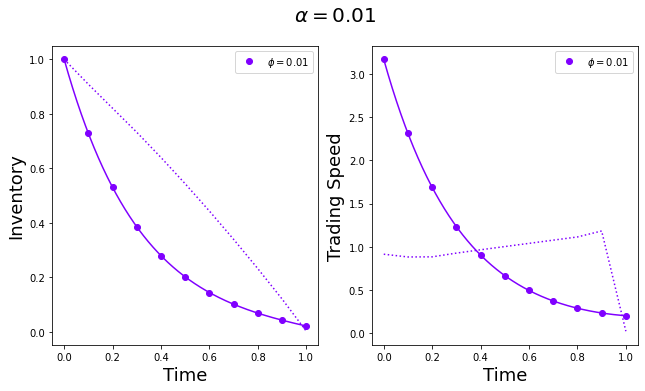

In [161]:
plot_inventory_trading_speed(0.01, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.01$")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


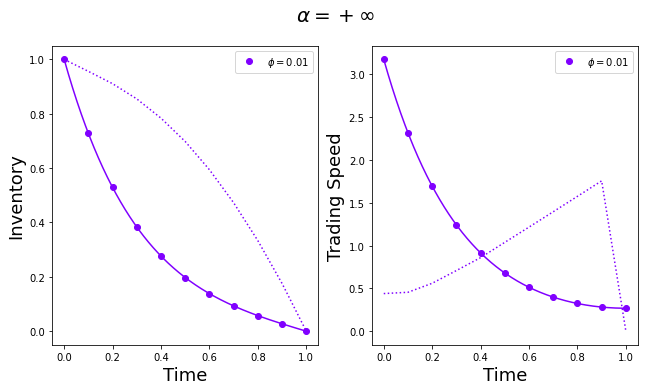

In [156]:
plot_inventory_trading_speed(100, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = +\infty$")